# An Example Physics Analysis

After all of the phases are run on a dataset, it is time to do some actual physics analysis! In general physics analysis is highly specific to the experiment being run, but this notebook aims to give a little overview on what an analysis might look like if one wants to use some of the tools given by the application. 

First we import our modules we need. We'll also define a helpful constant, which we'll use to convert $B\rho$ to momentum.

In [29]:
import sys
sys.path.append('..')
from spyral.core.config import load_config
from spyral.core.workspace import Workspace
from spyral.plot.histogram import Histogrammer
from spyral.core.target import Target
from spyral.core.constants import AMU_2_MEV
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
from scipy import constants

QBRHO_2_P: float = 1.0e-9 * constants.speed_of_light * 100.0 * 10.0 #T * m -> MeV/c

Now we'll load our configuration. The configuration will help us define the target material (the active target) which we'll use for some energy loss analysis. We'll also use the nuclear data map to get the masses for the reactants we're interested in. This example loads the data for the reaction $^{16}\mathrm{C}\left(\mathrm{d}, \mathrm{d}\right){}^{16}\mathrm{C}$ in inverse kinematics (where $^{16}\mathrm{C}$ is the beam projectile). We also define the projectile starting energy, that is the energy from the accelerator after passing through the window foils of the AT-TPC.

In [30]:
config = load_config('../local_config.json')
ws = Workspace(config.workspace)
nuclear_map = ws.get_nuclear_map()
target_material = Target(config.solver.gas_data_path, nuclear_map)
ejectile = nuclear_map.get_data(1, 2)
projectile = nuclear_map.get_data(6, 16)
target = nuclear_map.get_data(1, 2)
residual = nuclear_map.get_data(6, 16)
mass_amu = projectile.mass / AMU_2_MEV
proj_energy_start = 11.0 * mass_amu #MeV


Now we'll create a histogramming system. The Histogrammer class wraps the numpy histogramming functionality. This is useful because we'll probably want to look at several runs, and neither numpy or matplotlib provide clean native functionality for this. We'll define a couple of histograms that will plot some useful data for us. 

In [31]:

grammer = Histogrammer()
grammer.add_hist2d('ke_theta', (180, 1600), ((0.0, 90.0), (0.0, 80.0)))
grammer.add_hist2d('ke_phi', (360, 1600), ((0.0, 360.0), (0.0, 80.0)))
grammer.add_hist1d('ex', 250, (-5.0, 10.0))

Now we'll do some data analysis! Here we're going to calculate the ejectile (detected) particle kinetic energy from our fitted $B\rho$ and then combine that with the projectile kinetic energy, polar reaction angle, and masses to calculate the excitation energy of the residual nucleus. Note that we use the vertex position to calculate the distance travelled for the beam in the gas and then calculate the energy lost by the beam travelling to the reaction vertex. This data is then given to the histogrammer.

In [32]:
targ_vec = np.array([0., 0., 0., target.mass])
Q_mass = target.mass + projectile.mass - ejectile.mass - residual.mass
for run in range(config.run.run_min, config.run.run_max+1):
    df = None
    try:
        df = pl.read_parquet(ws.get_physics_file_path_parquet(run, ejectile))
    except Exception:
        continue

    vertices = df.select(['vertex_x', 'vertex_y', 'vertex_z']).to_numpy()
    distances = np.linalg.norm(vertices, axis=1)
    proj_energy = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, distances)

    brho = df.select('brho').to_numpy().flatten()
    momentum = df.select('brho').to_numpy().flatten() * float(ejectile.Z) * QBRHO_2_P
    kinetic_energy = np.sqrt(momentum**2.0 + ejectile.mass**2.0) - ejectile.mass
    polar = df.select('polar').to_numpy().flatten()
    az = df.select('azimuthal').to_numpy().flatten()

    qterm = 2.0/residual.mass * np.sqrt(projectile.mass * ejectile.mass * kinetic_energy * proj_energy) * np.cos(polar)
    Q_rxn = -1.0 * (kinetic_energy * (1.0 + ejectile.mass/residual.mass) + proj_energy * ( projectile.mass/residual.mass - 1.0) - qterm)

    grammer.fill_hist2d('ke_theta', np.rad2deg(polar), kinetic_energy)
    grammer.fill_hist2d('ke_theta_resid', np.rad2deg(polar), kinetic_energy)
    grammer.fill_hist2d('ke_phi', np.rad2deg(az), kinetic_energy)
    grammer.fill_hist1d('ex', Q_rxn + Q_mass)

We can also compare the kinematics to the expected values. Here we'll calculate the ejectile kinetic energy for a range of reaction angles. Note that in this case we cannot account for the exact beam energy after travelling through the gas without doing a form of Monte-Carlo simulation. By default we only calculate the ground state of the resiudal.

In [33]:
angle_range = np.linspace(0., np.pi*0.5, 1000)

ex = 0.0

Q = projectile.mass + target.mass - (ejectile.mass + residual.mass + ex)
term1 = np.sqrt(projectile.mass * ejectile.mass * proj_energy_start) / (ejectile.mass + residual.mass) * np.cos(angle_range)
term2 = (proj_energy_start * (residual.mass - projectile.mass) + residual.mass*Q) / (residual.mass + ejectile.mass)
eject_energy = term1 + np.sqrt(term1*term1 + term2)
eject_energy = eject_energy**2.0

Now lets make some plots! These first ones will be the energy-angle relationship for the ejectile (detected) particle. The interesting one is energy vs. polar ($\theta$). On this histogram we also plot our calculated energy angle relationship. Here we're looking for general agreement with the trend, not exact values. Because the calculation doesn't have a good way to handle the beam energy loss, the data will always look a little more "smeared" than the calculation would expect.

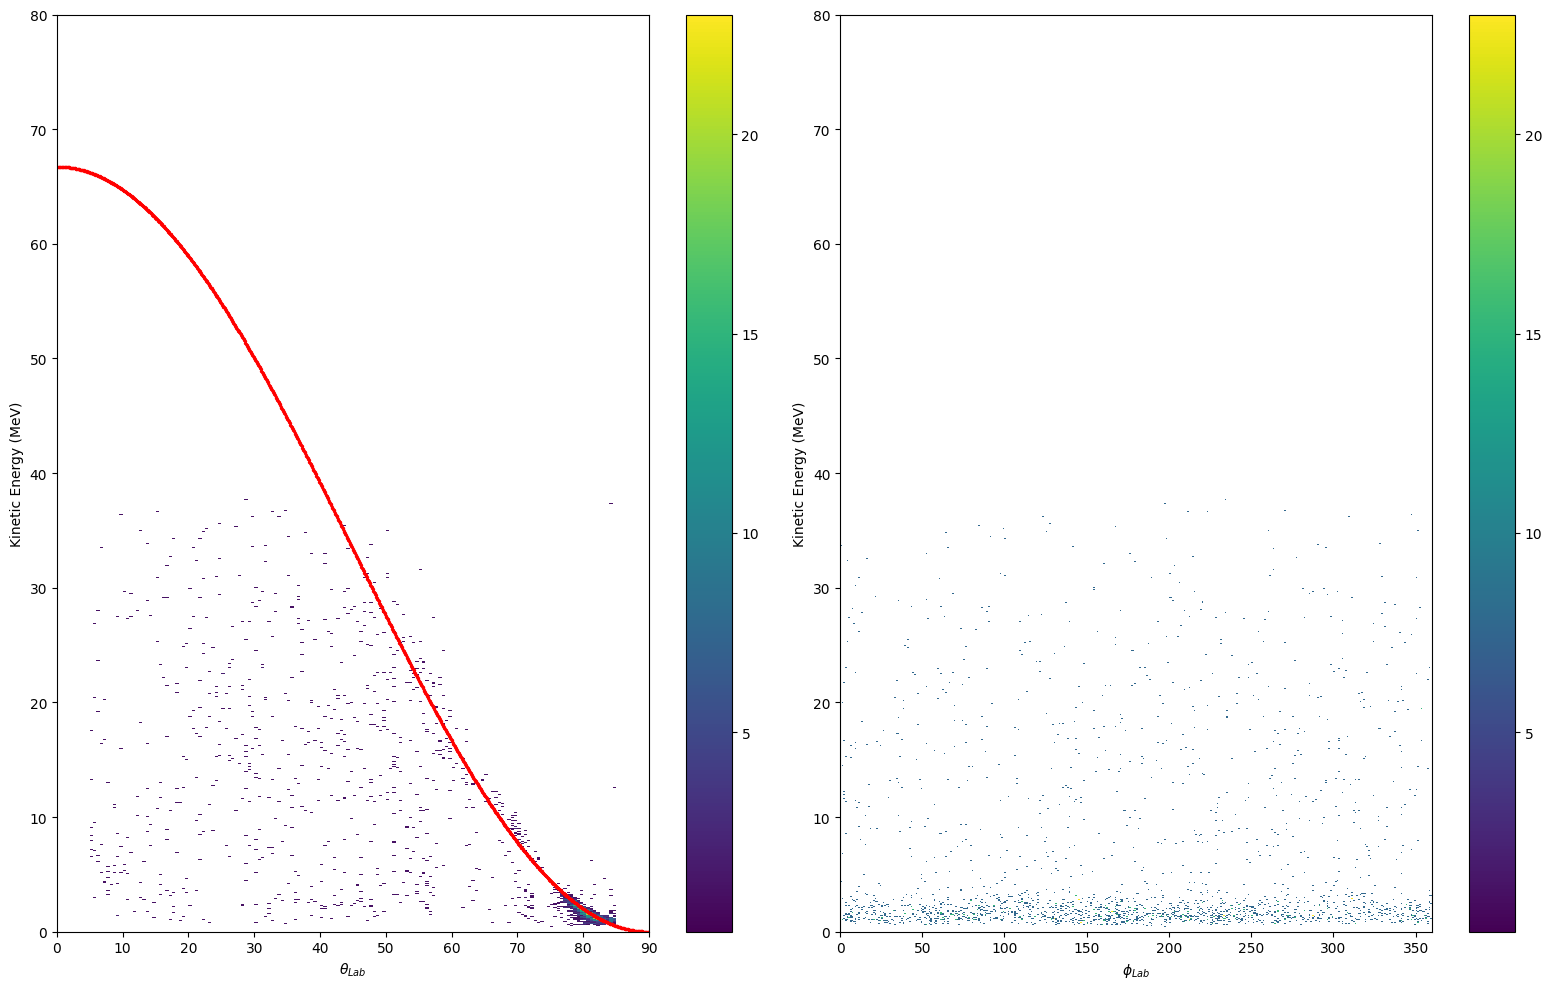

In [34]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(16)
fig.set_figheight(10)
mesh = grammer.draw_hist2d('ke_theta', ax[0], log_z=False)
ax[0].scatter(angle_range*180.0/np.pi, eject_energy, s=2, color='r')
ax[0].set_xlabel(r'$\theta_{Lab}$')
ax[0].set_ylabel('Kinetic Energy (MeV)')
ax[0].set_ylim(0.0, 80.0)
plt.colorbar(mesh, ax=ax[0])
mesh2 = grammer.draw_hist2d('ke_phi', ax[1], log_z=False)
ax[1].set_xlabel(r'$\phi_{Lab}$')
ax[1].set_ylabel('Kinetic Energy (MeV)')
plt.colorbar(mesh, ax=ax[1])
plt.tight_layout()

We'll also plot our calculated residual excitation energy. In many ways this is the primary plot of interest, as it should show you the states in the residual that were populated in the reaction with their relative intensities (uncorrected for detector efficiency of course).

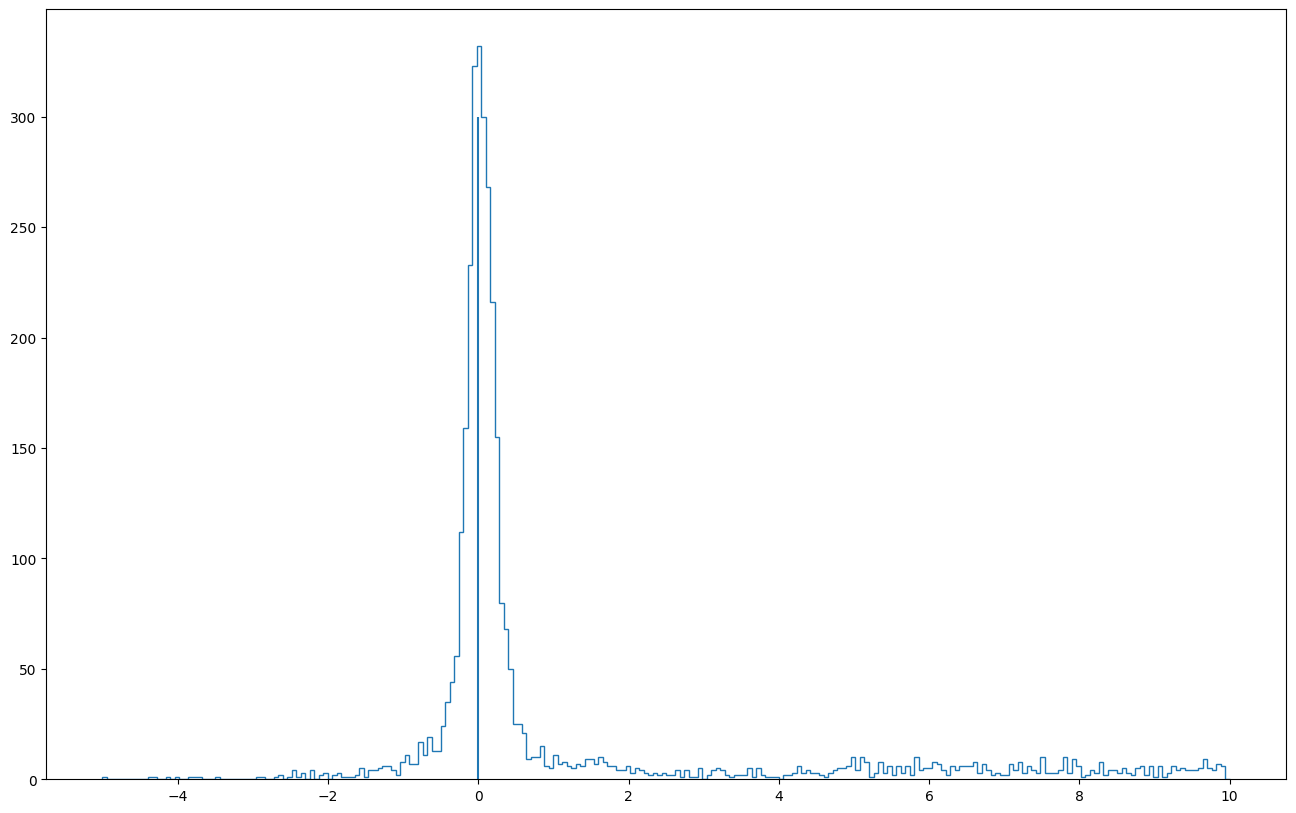

In [35]:
fig, ax = plt.subplots(1,1)
fig.set_figwidth(16)
fig.set_figheight(10)
grammer.draw_hist1d('ex', ax)
ax.vlines([0.0], [0.0], [300.0])

If the data you see doesn't match your expectations, there probably was an issue with one of the earlier analysis phases or the configuration parameters. Try  tweaking some the configuration parameters and see what it does to the final results!